Simple conv net

In [1]:
import numpy as np
import tensorflow as tf
import time
from tensorflow.python.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras import regularizers

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
    x = Conv2D(filters, (num_row, num_col),strides=strides,padding=padding,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [3]:
# setup parameters
num_classes = 8
classes = ['Airbus320', 'Airbus380', 'Boeing737', 'Boeing747', 'Boeing757', 'Boeing777', 'Boeing787', 'ERJ190']
target_size = (232, 348)
datapath_train = '../dataset3/train'
datapath_val = '../dataset3/val'

# hyper-parameters
lam = .005
batch_size = 64
lr = 1e-3
beta_1 = 0.9
beta_2 = 0.999
fcnum = 0
layer_cut = -1

In [4]:
inputs = Input(shape=(*target_size,3))
x = Conv2D(32, kernel_size=(5, 5), strides=(1, 1))(inputs)
#x = BatchNormalization()(x)
x = Activation(tf.nn.relu)(x)
x = Dropout(.5)(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Conv2D(64, (5, 5))(x)
x = Activation(tf.nn.relu)(x)
x = Dropout(.5)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(.5)(x)
x = Dense(1000, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)


#inputs = Input(shape=(*target_size,3))
#x = conv2d_bn(inputs, 32, 4,4, strides=(2, 2), padding='valid')
#x = MaxPooling2D((2, 2), strides=(1, 1))(x)

#x = conv2d_bn(x, 64, 3,3, strides=(2, 2), padding='valid')
#x = MaxPooling2D((3, 3), strides=(1, 1))(x)

#x = conv2d_bn(x, 128, 4,4, strides=(2, 2), padding='valid')
#x = MaxPooling2D((2, 2), strides=(2, 2))(x)

#x = Flatten()(x)
#outputs = Dense(num_classes, activation='softmax', kernel_initializer='glorot_normal', bias_initializer='zeros')(x)

model = Model(inputs, outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 232, 348, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 228, 344, 32)      2432      
_________________________________________________________________
activation_1 (Activation)    (None, 228, 344, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 228, 344, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 114, 172, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 168, 64)      51264     
_________________________________________________________________
activation_2 (Activation)    (None, 110, 168, 64)      0         
__________

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1./147, #preprocessing_function=preprocess_input_new,
    samplewise_center=True,
    rotation_range=0.0,
    horizontal_flip=False)

val_datagen = ImageDataGenerator(rescale = 1./147, samplewise_center=True) #preprocessing_function=preprocess_input

train_gen = train_datagen.flow_from_directory(
    datapath_train, 
    target_size=target_size, 
    batch_size=batch_size, 
    classes=classes,
    class_mode='categorical',
    shuffle=True)

val_gen = val_datagen.flow_from_directory(
    datapath_val, 
    target_size=target_size, 
    batch_size=batch_size, 
    classes=classes,
    class_mode='categorical',
    shuffle=True)

Found 22096 images belonging to 8 classes.
Found 1030 images belonging to 8 classes.


In [6]:
#set optimizer and loss 
opt = tf.keras.optimizers.SGD(lr=.01) #Adam(lr=1e-4, beta_1=beta_1, beta_2=beta_2)
loss = 'categorical_crossentropy'

#compile model
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [7]:
#train model
epochs = 10
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=val_gen)

Epoch 1/10
346/346 [==============================] - 262s 757ms/step - loss: 2.0012 - acc: 0.2179 - val_loss: 1.9822 - val_acc: 0.2621
Epoch 2/10
346/346 [==============================] - 255s 736ms/step - loss: 1.7971 - acc: 0.3307 - val_loss: 1.8664 - val_acc: 0.3612
Epoch 3/10
346/346 [==============================] - 255s 736ms/step - loss: 1.5759 - acc: 0.4325 - val_loss: 1.7890 - val_acc: 0.4058
Epoch 4/10
346/346 [==============================] - 254s 735ms/step - loss: 1.3030 - acc: 0.5421 - val_loss: 1.7085 - val_acc: 0.3845
Epoch 5/10
346/346 [==============================] - 254s 734ms/step - loss: 1.0071 - acc: 0.6522 - val_loss: 1.5974 - val_acc: 0.4777
Epoch 6/10
346/346 [==============================] - 254s 735ms/step - loss: 0.6951 - acc: 0.7636 - val_loss: 1.5118 - val_acc: 0.4864
Epoch 7/10
346/346 [==============================] - 255s 737ms/step - loss: 0.4090 - acc: 0.8663 - val_loss: 1.4725 - val_acc: 0.4786
Epoch 8/10
346/346 [============================

In [8]:
model.save('simple_conv1.h5')

In [ ]:
for i, lay in enumerate(model.layers):
    print(i, lay.name, lay.output_shape, lay.trainable)
    if 'mixed' in lay.name:
        print()

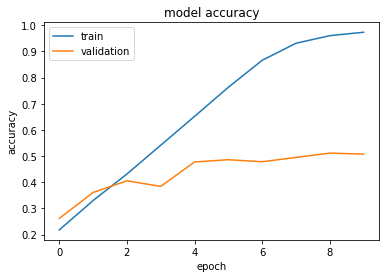

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

#acc = np.array([0.2325, 0.3411, 0.4399, 0.5494, 0.6736, 0.8194, 0.9236, 0.9703, 0.9865, 0.9840])
#val_acc = np.array([0.3299, 0.3715, 0.4323, 0.4479, 0.4323, 0.4670, 0.4601, 0.4896, 0.4740])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
test_gen = val_datagen.flow_from_directory(
    '../dataset3/test', 
    target_size=target_size, 
    batch_size=batch_size, 
    classes=classes,
    class_mode='categorical',
    shuffle=True)

model.evaluate_generator(test_gen)

Found 576 images belonging to 8 classes.


[1.3646965291765, 0.5034722222222222]